# Encoder

This notebook trains an autoencoder with all the cropped cells generated in crop_cell_segmentation.ipynb which encoder will be later used in supervised.ipynb

### Imports

In [36]:
import os
import sys
import random
import itertools

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model, clone_model
from tensorflow.keras.optimizers import Adam
from keras.optimizers import Adam

### Definitions

In [33]:
sys.path.insert(0, "../../")
from config import CROPPED_PATH, MODELS_PATH

# Paths
CROPS_PATH = os.path.join(CROPPED_PATH, 'ina', 'images')
ENCODER_PATH = os.path.join(MODELS_PATH, 'encoder')

# Configuration
SHAPE = (128,128,1)
BATCH_SIZE = 300
VALIDITAION_SPLIT = 0.2
ON_RAM = False


### Load dataset

In [19]:

if ON_RAM:

    images = np.zeros((len(os.listdir(CROPS_PATH)), SHAPE[0], SHAPE[1]))
    for idx, file in tqdm(enumerate(os.listdir(CROPS_PATH)), total=len(os.listdir(CROPS_PATH))):
        image = cv2.imread(os.path.join(CROPS_PATH, file), cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (SHAPE[0], SHAPE[1]))
        image = np.array(image) #

        images[idx, : ,:] = image


    from sklearn.model_selection import train_test_split
    x_train, x_test = train_test_split(images, test_size=VALIDITAION_SPLIT, random_state=42)
    x_train.shape

else:

    image_paths = [os.path.join(CROPS_PATH, file) for file in os.listdir(CROPS_PATH)]

    # Train / val split
    val_size = int(0.2 * len(image_paths))  # 20% para validación
    train_paths = image_paths[:-val_size]
    val_paths = image_paths[-val_size:]

    train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
    val_dataset = tf.data.Dataset.from_tensor_slices(val_paths)

    # Load & augmentation
    def load_image(path):

      image = tf.io.read_file(path)
      image = tf.image.decode_png(image, channels=1)  # Escala de grises
      image = tf.image.resize(image, (SHAPE[0], SHAPE[1]))
      # Augmentación

      image = tf.image.random_flip_left_right(image)
      image = tf.image.random_flip_up_down(image)
      image = tf.image.random_brightness(image, max_delta=0.1)
      image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
      scales = tf.random.uniform([], 0.8, 1.0)
      crop_size = tf.cast(scales * SHAPE[0], tf.int32)
      image = tf.image.random_crop(image, size=[crop_size, crop_size, 1])
      image = tf.image.resize(image, (SHAPE[0], SHAPE[1]))
      # Normalize [0, 1]
      image = tf.cast(image, tf.float32) / 255.0
      return image,image

    # Train dataset
    train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
    train_dataset = train_dataset.map(lambda x: load_image(x), num_parallel_calls=tf.data.AUTOTUNE)
    train_dataset = train_dataset.shuffle(buffer_size=10000)
    train_dataset = train_dataset.batch(BATCH_SIZE)
    train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
    train_dataset = train_dataset.repeat()

    # Val dataset
    validation_dataset = val_dataset.map(lambda x: load_image(x), num_parallel_calls=tf.data.AUTOTUNE)
    validation_dataset = validation_dataset.batch(BATCH_SIZE)
    validation_dataset = validation_dataset.prefetch(tf.data.AUTOTUNE)
    validation_dataset = validation_dataset.repeat()



In [20]:
len(train_paths)

42907

### Weigthed Loss: SSIM + MAE

In [21]:
class CustomLoss(tf.keras.losses.Loss):
    def __init__(self, y, z, name="custom_loss"):
        super().__init__(name=name)
        # Weights
        self.y = y
        self.z = z

        #MAE
        self.mae_loss_fn = tf.keras.losses.MeanAbsoluteError()

    # SSIM loss
    def ssim_loss(self, y_true, y_pred):

        ssim = (1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))) / 2
        return ssim

    def call(self, y_true, y_pred):

        mae_loss = self.mae_loss_fn(y_true, y_pred)
        ssim = self.ssim_loss(y_true, y_pred)


        return  self.y * mae_loss + self.z * ssim

### AutoEncoder

In [22]:
kernel_size = (4,4)
filter = 32

# Encoder
encoder_input = layers.Input(shape=(128, 128, 1))

x = encoder_input

x = layers.Rescaling(1.0 / 255.0)(x)


x = layers.Conv2D(filter, kernel_size, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D((2, 2), padding='same')(x)

x = layers.Conv2D(filter//2, kernel_size, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D((2, 2), padding='same')(x)

x = layers.Conv2D(filter//4, kernel_size, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D((2, 2), padding='same')(x)

x = layers.Conv2D(filter//8, kernel_size, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D((2, 2), padding='same')(x)

x = layers.Conv2D(filter//16, kernel_size, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D((2, 2), padding='same')(x)

x = layers.Flatten()(x)

encoder_output = x


encoder = Model(encoder_input, encoder_output)

# Decoder

decoder_input = layers.Input(shape=[encoder.output_shape[-1]])

x = decoder_input

x = layers.Reshape((2*filter//16, 2*filter//16, filter//16))(x)


x = layers.Conv2D(filter//16, kernel_size, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)

x = layers.Conv2D(filter//8, kernel_size, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)

x = layers.Conv2D(filter//4, kernel_size, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)

x = layers.Conv2D(filter//2, kernel_size, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)

x = layers.Conv2D(filter, kernel_size, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)

x = layers.Conv2D(1, kernel_size, activation='sigmoid', padding='same')(x)

#x = layers.Rescaling(255.0)(x)

decoder_output = x

decoder = Model(decoder_input, decoder_output)

# Build the autoencoder model
# autoencoder = Model(encoder_input, decoder_output)
autoencoder = Sequential([
    encoder,
    decoder
])

In [23]:
encoder.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 128, 128, 32)   │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 16)     │         8,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64, 64, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 8)      │         2,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 32, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 4)      │           516 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 16, 16, 4)      │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 8, 8, 4)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 8, 8, 2)        │           130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 8, 8, 2)        │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 4, 4, 2)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,702 (45.71 KB)

 Trainable params: 11,578 (45.23 KB)

 Non-trainable params: 124 (496.00 B)

In [24]:
decoder.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 4, 4, 2)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 4, 4, 2)        │            66 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 4, 4, 2)        │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 8, 8, 2)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 8, 8, 4)        │           132 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 8, 8, 4)        │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_6 (UpSampling2D)  │ (None, 16, 16, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 16, 16, 8)      │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 16, 16, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_7 (UpSampling2D)  │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 32, 32, 16)     │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_8 (UpSampling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 64, 64, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_9 (UpSampling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 128, 128, 1)    │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,767 (45.96 KB)

 Trainable params: 11,643 (45.48 KB)

 Non-trainable params: 124 (496.00 B)

In [25]:
# Summary of the model
autoencoder.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_22 (Functional)      │ (None, 32)             │        11,702 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_23 (Functional)      │ (None, 128, 128, 1)    │        11,767 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,469 (91.68 KB)

 Trainable params: 23,221 (90.71 KB)

 Non-trainable params: 248 (992.00 B)

### Compile & fit - Grid search

In [26]:
# Weight range from 0.2 to 1
y_values = np.arange(0.2, 1.2, 0.2)
z_values = np.arange(0.2, 1.2, 0.2)

# Combinations of weights
param_combinations = list(itertools.product(y_values,z_values))

random.seed(34)
random.shuffle(param_combinations)

# Normalize weights ---> y + z = 1
def normalize_weights(weights):
    total_sum = sum(weights)
    return tuple(weight / total_sum for weight in weights)

param_combinations = [normalize_weights(weights) for weights in param_combinations]
param_combinations =set(param_combinations) #delete duplicate
print("Total combinations: ", len(param_combinations))
for i,combination in enumerate(param_combinations):
    print(f"Combination {i+1}: ", tuple(map(float, combination)))

Total combinations:  19
Combination 1:  (0.25, 0.7500000000000001)
Combination 2:  (0.37500000000000006, 0.625)
Combination 3:  (0.3333333333333333, 0.6666666666666666)
Combination 4:  (0.7142857142857143, 0.28571428571428575)
Combination 5:  (0.4285714285714286, 0.5714285714285714)
Combination 6:  (0.4444444444444445, 0.5555555555555556)
Combination 7:  (0.5555555555555556, 0.4444444444444445)
Combination 8:  (0.7500000000000001, 0.25)
Combination 9:  (0.5, 0.5)
Combination 10:  (0.28571428571428575, 0.7142857142857143)
Combination 11:  (0.5714285714285714, 0.4285714285714286)
Combination 12:  (0.625, 0.37500000000000006)
Combination 13:  (0.8333333333333334, 0.16666666666666669)
Combination 14:  (0.6000000000000001, 0.4)
Combination 15:  (0.6666666666666666, 0.3333333333333333)
Combination 16:  (0.2, 0.8)
Combination 17:  (0.4, 0.6000000000000001)
Combination 18:  (0.8, 0.2)
Combination 19:  (0.16666666666666669, 0.8333333333333334)


In [27]:
def evaluate_model(autoencoder, train_gen, val_gen, params, steps_per_epoch, val_steps):
    y, z = [np.round(arr, 2) for arr in params]

    loss_fn = CustomLoss(y=y, z=z)
    model = clone_model(autoencoder)
    model.compile(
        loss=loss_fn,
        optimizer=Adam(learning_rate=1e-3)
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=0
    )

    history=model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        epochs=20,
        validation_data=val_gen,
        validation_steps=val_steps,
        callbacks=[early_stop],
        verbose=1
        )

    val_loss = min(history.history['val_loss'])
    return val_loss


best_params = None
best_loss = float('inf')


steps_per_epoch = int(len(train_paths) // BATCH_SIZE)
steps_per_epoch_val = int(len(val_paths) // BATCH_SIZE)


# Evaluate Autoencoder for all the combinations of weights
for params in param_combinations:
    try:
        val_loss = evaluate_model(autoencoder, train_dataset, validation_dataset, params, steps_per_epoch, steps_per_epoch_val)
        print(f"Params {params} -> Val Loss: {val_loss}")

        if val_loss < best_loss:
            best_loss = val_loss
            best_params = params
    except Exception as e:
        print(f"{e}")



Epoch 1/20


I0000 00:00:1746274055.111773   45918 service.cc:152] XLA service 0x7e3b94005a50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746274055.111790   45918 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-05-03 09:07:35.190480: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-03 09:07:35.378868: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/custom_loss/SSIM/Assert/Assert
2025-05-03 09:07:35.379160: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/custom_loss/SSIM/Assert_1/Assert
2025-05-03 09:07:35.379364: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/custom_loss/SSIM/Assert_2/Assert
2025-05-03 09:07:35.379608: W tensorflow/compiler/tf2xla/k

  2/143 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - loss: 0.4014 

I0000 00:00:1746274068.556534   45918 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.2693

2025-05-03 09:07:59.348898: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/custom_loss/SSIM/Assert/Assert
2025-05-03 09:07:59.349266: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/custom_loss/SSIM/Assert_1/Assert
2025-05-03 09:07:59.349482: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/custom_loss/SSIM/Assert_2/Assert
2025-05-03 09:07:59.349626: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/custom_loss/SSIM/Assert_3/Assert


143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 85ms/step - loss: 0.2691 - val_loss: 0.2667
Epoch 2/20


2025-05-03 09:08:01.029819: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/custom_loss/SSIM/Assert/Assert
2025-05-03 09:08:01.029915: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/custom_loss/SSIM/Assert_1/Assert
2025-05-03 09:08:01.029986: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/custom_loss/SSIM/Assert_2/Assert
2025-05-03 09:08:01.030022: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/custom_loss/SSIM/Assert_3/Assert


143/143 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - loss: 0.2264 - val_loss: 0.2616
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - loss: 0.2230 - val_loss: 0.2625
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - loss: 0.2206 - val_loss: 0.2513
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - loss: 0.2192 - val_loss: 0.2274
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - loss: 0.2183 - val_loss: 0.2594
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - loss: 0.2167 - val_loss: 0.2471
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - loss: 0.2163 - val_loss: 0.2412
Epoch 9/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - loss: 0.2159 - val_loss: 0.2219
Epoch 10/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - loss: 0.2158 - val_loss: 0.2736
Epoch 11/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - loss: 0.2153 - val_loss: 0.2202
Epoch 12/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - loss: 0.2154 - val_loss: 0.2283
Epoch 13/20
143/143 ━━━━━━━━━━━━━━━━━━━━

2025-05-03 09:11:21.070010: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/custom_loss/SSIM/Assert/Assert
2025-05-03 09:11:21.070376: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/custom_loss/SSIM/Assert_1/Assert
2025-05-03 09:11:21.070593: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/custom_loss/SSIM/Assert_2/Assert
2025-05-03 09:11:21.070734: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/custom_loss/SSIM/Assert_3/Assert


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.2498

2025-05-03 09:11:34.393549: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/custom_loss/SSIM/Assert/Assert
2025-05-03 09:11:34.393894: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/custom_loss/SSIM/Assert_1/Assert
2025-05-03 09:11:34.394097: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/custom_loss/SSIM/Assert_2/Assert
2025-05-03 09:11:34.394237: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/custom_loss/SSIM/Assert_3/Assert


143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - loss: 0.2496 - val_loss: 0.2477
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - loss: 0.2033 - val_loss: 0.2531
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - loss: 0.1977 - val_loss: 0.2500
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - loss: 0.1954 - val_loss: 0.2310
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - loss: 0.1963 - val_loss: 0.2921
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - loss: 0.1932 - val_loss: 0.2426
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - loss: 0.1926 - val_loss: 0.3281
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - loss: 0.1917 - val_loss: 0.2607
Epoch 9/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - loss: 0.1917 - val_loss: 0.3190
Params (np.float64(0.37500000000000006), np.float64(0.625)) -> Val Loss: 0.23096607625484467
Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - loss: 0.2656 - val_loss: 0.2773
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━

In [28]:
# Resultados finales
print(f"Best Params: {best_params} -> Best Val Loss: {best_loss}")

Best Params: (np.float64(0.8333333333333334), np.float64(0.16666666666666669)) -> Best Val Loss: 0.10399342328310013


### Compile y fit: Best Params

In [29]:
loss_fn = CustomLoss(y=0.83, z=0.17)

steps_per_epoch = int(len(train_paths) // BATCH_SIZE)
steps_per_epoch_val = int(len(val_paths) // BATCH_SIZE)

autoencoder.compile(
    loss=loss_fn,
    optimizer=Adam(learning_rate=1e-3)
)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=0
)

autoencoder.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=100,
    validation_data=validation_dataset,
    validation_steps=steps_per_epoch_val,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100


143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 80ms/step - loss: 0.1796 - val_loss: 0.2031
Epoch 2/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - loss: 0.1166 - val_loss: 0.2075
Epoch 3/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - loss: 0.1111 - val_loss: 0.1951
Epoch 4/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - loss: 0.1082 - val_loss: 0.1740
Epoch 5/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - loss: 0.1062 - val_loss: 0.1444
Epoch 6/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - loss: 0.1056 - val_loss: 0.1082
Epoch 7/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - loss: 0.1043 - val_loss: 0.1061
Epoch 8/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - loss: 0.1040 - val_loss: 0.1064
Epoch 9/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - loss: 0.1030 - val_loss: 0.1017
Epoch 10/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - loss: 0.1031 - val_loss: 0.1043
Epoch 11/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - loss: 0.1027 - val_loss: 0.1086
Epoch 12/100
143/143 ━━━━━━━━━━

In [35]:
os.makedirs(ENCODER_PATH, exist_ok=True)
encoder.save(os.path.join(ENCODER_PATH, 'encoder_SSIM_MAE_Bparams.keras'))

### Results

<Axes: >

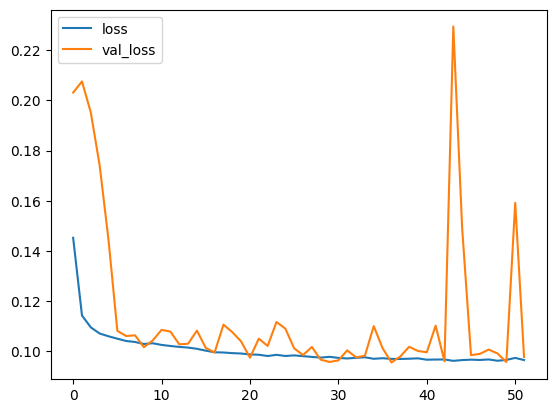

In [37]:
metrics = pd.DataFrame(autoencoder.history.history)
metrics[['loss', 'val_loss']].plot()

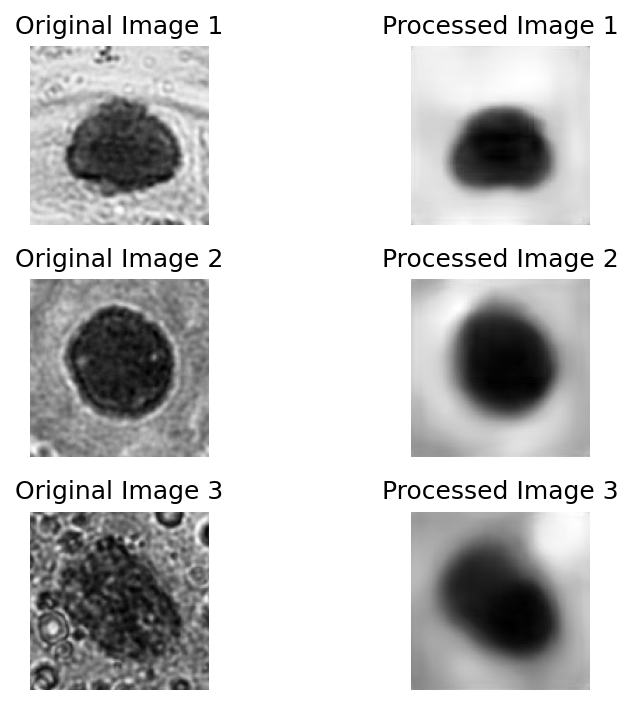

In [38]:
validation_images = validation_dataset.take(1)


for images, _ in validation_images:
    shuffled_images = tf.random.shuffle(images)
    first_three_images = shuffled_images[:3]
    break

processed_images = []
for img in first_three_images:
    img_with_batch = tf.expand_dims(img, axis=0)
    processed_image = autoencoder(img_with_batch).numpy()
    processed_images.append(processed_image.squeeze())

#Plot
n = 0
plt.figure(dpi=150)

plt.subplot(3, 2, 1)
plt.imshow(first_three_images[n], cmap='gray')  # Mostrar la imagen original
plt.axis(False)
plt.title(f"Original Image {n+1}")

plt.subplot(3, 2, 2)
plt.imshow(processed_images[n], cmap='gray')  # Mostrar la imagen procesada
plt.axis(False)
plt.title(f"Processed Image {n+1}")


n = 1
plt.subplot(3, 2, 3)
plt.imshow(first_three_images[n], cmap='gray')
plt.axis(False)
plt.title(f"Original Image {n+1}")

plt.subplot(3, 2, 4)
plt.imshow(processed_images[n], cmap='gray')
plt.axis(False)
plt.title(f"Processed Image {n+1}")


n = 2
plt.subplot(3, 2, 5)
plt.imshow(first_three_images[n], cmap='gray')
plt.axis(False)
plt.title(f"Original Image {n+1}")

plt.subplot(3, 2, 6)
plt.imshow(processed_images[n], cmap='gray')
plt.axis(False)
plt.title(f"Processed Image {n+1}")

plt.tight_layout()
plt.show()